In [152]:
from tensorflow.keras.models import load_model
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score

In [2]:
source_dir_1 = '/kaggle/input/brain-tumor-mri-dataset/Training/glioma'
source_dir_2 = '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma'
source_dir_3 = '/kaggle/input/brain-tumor-mri-dataset/Training/notumor'
source_dir_4 = '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary'

In [3]:
test_dir_1 = '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma'
test_dir_2 = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma'
test_dir_3 = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor'
test_dir_4 = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary'

In [4]:
images = []
labels = []
files = [f for f in sorted(os.listdir(source_dir_1))]
for file in tqdm(files):
    file_path = os.path.join(source_dir_1, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images.append(img)
    labels.append(0)

100%|██████████| 1321/1321 [00:12<00:00, 105.58it/s]


In [5]:
files = [f for f in sorted(os.listdir(source_dir_2))]
for file in tqdm(files):
    file_path = os.path.join(source_dir_2, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images.append(img)
    labels.append(1)


100%|██████████| 1339/1339 [00:13<00:00, 95.82it/s] 


In [6]:
files = [f for f in sorted(os.listdir(source_dir_3))]
for file in tqdm(files):
    file_path = os.path.join(source_dir_3, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images.append(img)
    labels.append(2)


100%|██████████| 1595/1595 [00:15<00:00, 100.25it/s]


In [7]:
files = [f for f in sorted(os.listdir(source_dir_4))]
for file in tqdm(files):
    file_path = os.path.join(source_dir_4, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images.append(img)
    labels.append(3)


100%|██████████| 1457/1457 [00:15<00:00, 96.23it/s] 


In [8]:
images = np.array(images)
labels = np.array(labels)
images = tf.cast(images, tf.float32) / 255.0
images.shape

TensorShape([5712, 256, 256, 3])

In [9]:
images_test = []
labels_test = []
files = [f for f in sorted(os.listdir(test_dir_1))]
for file in tqdm(files):
    file_path = os.path.join(test_dir_1, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images_test.append(img)
    labels_test.append(0)


100%|██████████| 300/300 [00:03<00:00, 97.84it/s] 


In [10]:
files = [f for f in sorted(os.listdir(test_dir_2))]
for file in tqdm(files):
    file_path = os.path.join(test_dir_2, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images_test.append(img)
    labels_test.append(1)


100%|██████████| 306/306 [00:03<00:00, 84.22it/s]


In [11]:
files = [f for f in sorted(os.listdir(test_dir_3))]
for file in tqdm(files):
    file_path = os.path.join(test_dir_3, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images_test.append(img)
    labels_test.append(2)


100%|██████████| 405/405 [00:03<00:00, 109.15it/s]


In [12]:
files = [f for f in sorted(os.listdir(test_dir_4))]
for file in tqdm(files):
    file_path = os.path.join(test_dir_4, file)
    img = Image.open(file_path).resize((256,256)).convert('RGB')
    img = np.array(img)
    images_test.append(img)
    labels_test.append(3)


100%|██████████| 300/300 [00:02<00:00, 106.74it/s]


In [13]:
images_test = np.array(images_test)
labels_test = np.array(labels_test)
images_test = tf.cast(images_test, tf.float32) / 255.0
images_test.shape

TensorShape([1311, 256, 256, 3])

In [14]:
model = load_model('/kaggle/input/unet-model/keras/default/1/unet-model.h5', compile = False)

In [15]:
predictions = model.predict(images)

I0000 00:00:1732860287.319155      76 service.cc:145] XLA service 0x79189011cb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732860287.319215      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/179 ━━━━━━━━━━━━━━━━━━━━ 1:07:47 23s/step

I0000 00:00:1732860309.600270      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 304ms/step


In [16]:
predictions_test = model.predict(images_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 686ms/step


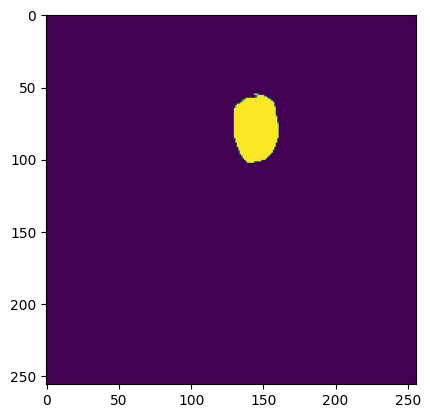

In [12]:
plt.imshow(predictions[100])

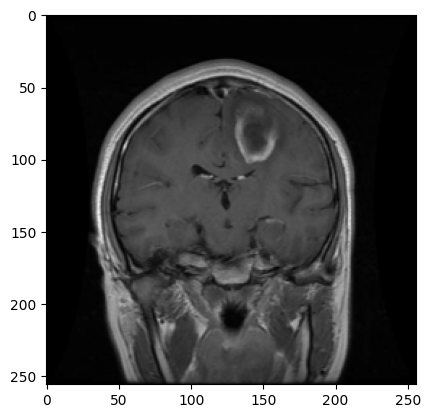

In [13]:
plt.imshow(np.array(images[100]))

In [17]:
predictions = predictions.reshape(5712, -1)

In [18]:
predictions_test = predictions_test.reshape(1311, -1)

In [233]:
pca = PCA(n_components=100)
pca.fit(np.concatenate((predictions, predictions_test), axis=0))
tumor_pca = pca.transform(predictions)
tumor_pca.shape

(5712, 100)

In [234]:
tumor_pca_test = pca.transform(predictions_test)
tumor_pca_test.shape

(1311, 100)

In [235]:
tumor_pca_train, labels_train = shuffle(tumor_pca, labels)

In [320]:
svm = SVC(kernel = 'rbf', C=13, gamma=0.01)
svm.fit(tumor_pca_train, labels_train)

SVC(C=13, gamma=0.01)

In [321]:
svm.score(tumor_pca, labels)

0.946953781512605

In [322]:
svm.score(tumor_pca_test, labels_test)

0.8245614035087719

In [323]:
svm_predictions = svm.predict(tumor_pca_test)

In [327]:
fbeta_score(svm_predictions, labels_test, beta=10, average='weighted')

0.8245787823280673

In [328]:
temp_labels = np.where(np.isin(labels_test, [0, 1, 3]), 0, 1)

In [329]:
svm_predictions = np.where(np.isin(labels_test, [0,1,3]), 0, 1)

In [330]:
fbeta_score(svm_predictions, temp_labels, beta=2, average='weighted')

1.0